In [1]:
import cv2
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

from tqdm import tqdm, trange


In [2]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(
                i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result


class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding.
    https://github.com/facebookresearch/segment-anything/blob/6fdee8f2727f4506cfbbe553e23b895e27956588/segment_anything/modeling/image_encoder.py#L364
    """

    def __init__(
        self,
        kernel_size=(4, 4),
        stride=(4, 4),
        padding=(0, 0),
        in_chans: int = 1,
        embed_dim: int = 16,
    ) -> None:
        """
        Args:
            kernel_size (Tuple): kernel size of the projection layer.
            stride (Tuple): stride of the projection layer.
            padding (Tuple): padding size of the projection layer.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
        """
        super().__init__()

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        # B C H W -> B H W C
        x = x.permute(0, 2, 3, 1)
        return x


class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

class ViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=16, n_heads=2, n_blocks=2, out_d=2):
        super(ViT, self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.hidden_d = hidden_d

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

        # Patcher and mapper
        self.patcher = PatchEmbed()
        self.mapper = nn.Linear(16, hidden_d)

        # Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        #  Positional embedding
        self.register_buffer('pos_embed', get_positional_embeddings(
            n_patches ** 2 + 1, hidden_d), persistent=False)

        # Attention blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # MLP classification
        # self.mlp = nn.Sequential(
        #     nn.Linear(self.hidden_d, out_d),
        #     nn.Softmax(dim=-1)
        # )

    def forward(self, images):
        tokens = self.patcher(images).flatten(1, 2)
        tokens = self.mapper(tokens)

        tokens = torch.cat((self.class_token.expand(
            len(tokens), 1, -1), tokens), dim=1)

        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(len(tokens), 1, 1)
        out = tokens + pos_embed

        for block in self.blocks:
            out = block(out)

        # out = self.mlp(out[:, 0])

        return out[:, 0]

In [3]:
class TokenEncoder(nn.Module):
    """
    Adapted from:
    https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/modeling/prompt_encoder.py
    """
    def __init__(self, image_size:int = 28, num_pos_feats:int = 8) -> None:
        super().__init__()
        self.image_size = image_size

        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            torch.randn((2, num_pos_feats)),
        )

    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """Positionally encode points that are normalized to [0,1]."""
        # assuming coords are in [0, 1]^2 square and have d_1 x ... x d_n x 2 shape
        coords = 2 * coords - 1
        coords = coords @ self.positional_encoding_gaussian_matrix
        coords = 2 * np.pi * coords
        # outputs d_1 x ... x d_n x C shape
        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, coords_input):
        """
        Arguments:
        points: batch points predictions in formart [B, W, H]
        """
        coords = coords_input.clone()
        coords[:, 0] = coords[:, 0] / self.image_size
        coords[:, 1] = coords[:, 1] / self.image_size
        t = self._pe_encoding(coords.to(torch.float))  # B x N
        return t

In [4]:
class Net(nn.Module):
    def __init__(self, hidden_d:int = 8, n_heads:int = 1, n_blocks:int = 1, out_d:int = 2, image_size:int = 28) -> None:
        super().__init__()
        self.max = 30

        self.enconder = ViT(hidden_d=hidden_d, n_heads=n_heads)
        self.token_enconder = TokenEncoder(num_pos_feats=4)
        self.image_size = image_size

        # Attention blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        self.pred = nn.Sequential(
            nn.Linear(hidden_d, out_d),
            nn.Sigmoid()
        )

        self.flag = nn.Sequential(
            nn.Linear(hidden_d, 1),
            nn.Sigmoid()
        )

    def forward(self, image, input_token, in_tokens=None):
        token = self.token_enconder(input_token).unsqueeze(1)
        embedding = self.enconder(image).unsqueeze(1)

        tokens = torch.cat([token, embedding], dim=1)

        if in_tokens is not None:
          tokens = torch.cat([tokens, in_tokens], dim=1)

        for block in self.blocks:
          tokens = block(tokens)

        point = self.pred(tokens)[:, 0]

        return point, tokens

        tokens = self.enconder(image)
        # token = self.token_enconder(input_token)

        i = 0
        stop = 0
        points = []
        while(i < self.max):
            token = self.token_enconder(input_token)
            tokens = torch.cat([token.unsqueeze(1), tokens.unsqueeze(1)], dim=1)

            for block in self.blocks:
                tokens = block(tokens)

            tokens = tokens[:, 1]
            input_token = self.pred(tokens)
            # stop = self.flag(tokens) > 0.5
            points.append(input_token.unsqueeze(1) * self.image_size)
            i += 1
        return torch.cat(points, dim=1)


# x = torch.randn(2, 1, 28, 28).to("cuda")
# z = torch.randn(2, 2).to("cuda")
# model = Net().to("cuda")
# out = model(x, z)
# print(out.shape)
# print(out)

In [7]:
SIZE = 28
MAX=10

def preprocess(img, toTensor):
  cnt, _ = cv2.findContours(np.array(img), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cnt = max(cnt, key=cv2.contourArea)
  poly = cv2.approxPolyDP(cnt, 0.025 * cv2.arcLength(cnt, True), True) / SIZE
  poly = torch.tensor(poly.reshape(-1, 2), dtype=torch.float32)

  if (len(poly) < MAX):
    zeros = torch.zeros(MAX - len(poly), 2)
    poly = torch.cat([poly, zeros])

  poly[MAX - 1] = torch.tensor([0, 0], dtype=torch.float32)

  return toTensor(img), poly[:MAX]

# Loading data
transform = ToTensor()
train_set = MNIST(root='./datasets', train=True,
                  download=True, transform=Lambda(lambda x: preprocess(x, transform)))
test_set = MNIST(root='./datasets', train=False,
                 download=True, transform=Lambda(lambda x: preprocess(x, transform)))
train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

In [8]:
if __name__ == "__main__":
    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device_name = torch.cuda.get_device_name(device) if torch.cuda.is_available() else "cpu"
    print("Using device: ", device, f"({device_name})")

    model = Net().to(device)
    N_EPOCHS = 5
    LR = 0.005

    # model.load_state_dict(torch.load("/content/train_1.pth"))

    batch_images, batch_labels = next(iter(train_loader))
    # print(batch_images.shape, batch_labels.shape)

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = MSELoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, _ = batch
            img, poly = x

            if len(img) < 128:
              continue

            img = img.to(device)
            poly = poly.to(device)
            inputs = torch.zeros(128, 2).to(device)

            optimizer.zero_grad()
            loss = 0.0
            tokens = None

            for i in range(MAX):
              preds, tokens = model(img, inputs, tokens)

              # print(preds[0], poly[0, i])
              loss += criterion(preds, poly[:, i, :])

              inputs = preds

            train_loss += loss.detach().cpu().item() / len(train_loader)
            # print(f"Step loss: {loss:.2f}")
            loss.backward()
            optimizer.step()


        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")



Using device:  cuda (Quadro M5000)


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:  20%|██        | 1/5 [45:03<3:00:14, 2703.54s/it]

Epoch 1/5 loss: 0.45


Training:  40%|████      | 2/5 [1:29:59<2:14:56, 2698.83s/it]

Epoch 2/5 loss: 0.38


Training:  60%|██████    | 3/5 [2:14:53<1:29:53, 2696.66s/it]

Epoch 3/5 loss: 0.35


Training:  80%|████████  | 4/5 [2:59:44<44:54, 2694.76s/it]  

Epoch 4/5 loss: 0.34


Training: 100%|██████████| 5/5 [3:44:37<00:00, 2695.44s/it]

Epoch 5/5 loss: 0.33


In [9]:
# Test loop
# with torch.no_grad():
#   correct, total = torch.zeros(128, 1), 0
#   test_loss = 0.0
#   inputs = torch.zeros(128, 2).to(device)

#   for batch in tqdm(test_loader, desc="Testing"):
#     # x, y = x.to(device), y.to(device)
#     x, _ = batch
#     img, poly = x

#     if len(img) < 128:
#         break

#     tokens = None
#     for i in range(10):
#       pred, tokens = model(img, inputs, tokens)
#       loss = criterion(pred, poly[:, i, :])
#       test_loss += loss.detach().cpu().item() / len(test_loader)

#     # correct += torch.sum(torch.argmax(pred, dim=0) == poly).detach().cpu().item()
#     print(pred[0], poly[0, 0])
#     correct = torch.cdist(pred, poly[:, 0, :], p=2)
#     total += len(img)

#   print(torch.sum(correct), total)
#   print(f"Test loss: {test_loss:.2f}")
#   print(f"Test accuracy: {torch.sum(correct) / total:.2f}")

In [10]:
path = "train_1.pth"
torch.save(model.state_dict(), path)

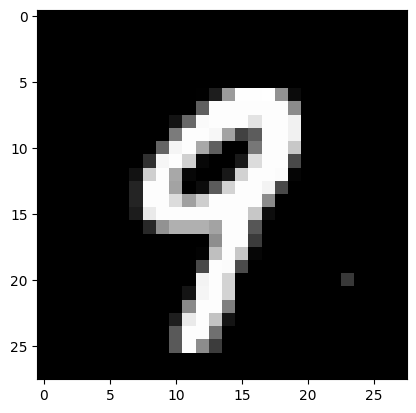

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

img = batch_images[0].numpy()[0][0] * 255
img = img.astype(np.uint8)
plt.imshow(img, cmap='gray')

In [ ]:
cnt, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt = max(cnt, key=cv2.contourArea)

poly = cv2.approxPolyDP(cnt, 0.025 * cv2.arcLength(cnt, True), True)

out = np.zeros((28,28, 3))
out[:,:, 1] = np.copy(img)

cv2.polylines(out, [poly], True, (0, 0, 255))

for p in poly:
    cv2.circle(out, p[0], radius=0, color=255, thickness=-1)

plt.imshow(out)

In [ ]:
with torch.no_grad():
  inputs = torch.zeros(1, 2).to(device)
  image = batch_images[0][0].reshape(1, 1, 28, 28).to(device)

  # print(batch_images[0][1].shape, image.shape)

  poly = []
  tokens = None
  for i in range(MAX):
    # print(tokens.shape)
    point, tokens = model(image, inputs, tokens)
    inputs = point

    poly.append(point)
    if point[0][0] == 0 and point[0][1] == 0:
      break

poly = torch.cat(poly)
print(poly[:-1], poly[:].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


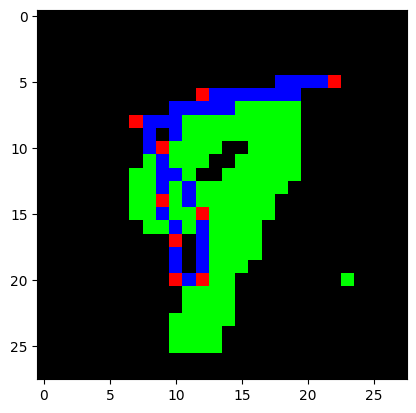

In [62]:
np_poly = poly[:-1].unsqueeze(1).to('cpu').numpy() * SIZE
np_poly = np_poly.astype(np.int32)

np_out = np.zeros((28,28, 3))
np_out[:,:, 1] = np.copy(img)

cv2.polylines(np_out, [np_poly], True, (0, 0, 255))

for p in np_poly:
    cv2.circle(np_out, p[0], radius=0, color=255, thickness=-1)

plt.imshow(np_out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


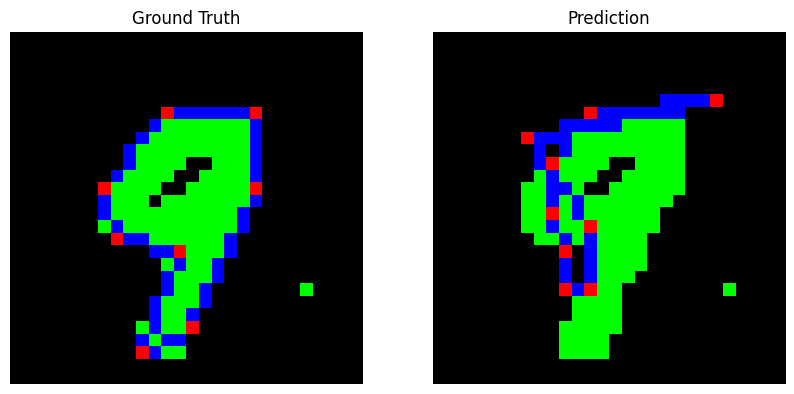

In [63]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)
plt.imshow(out)
plt.axis('off')
plt.title("Ground Truth")

fig.add_subplot(1, 2, 2)

plt.imshow(np_out)
plt.axis('off')
plt.title("Prediction")

plt.show()